# Третье практическое задание. Реализация дропаута в рекуррентных нейронных сетях
Практикум на ЭВМ для 317 группы, весна 2022

#### Фамилия, имя: Янаков Дмитрий

Дата выдачи: 3 апреля 18:00

Мягкий дедлайн: 17 апреля 23:59

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# Часть 0. Загрузка и предобработка данных. (1 балл)

## Рекомендуемые гиперпараметры

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать -- скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## Загрузка и предобработка данных

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [ ]:
!tar -xvzf aclImdb_v1.tar.gz

Посмотрите в файле `./aclImdb/README` как организованы данные

In [ ]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [4]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [5]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти -- размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [8]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [6]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    new_text = text.lower()
    new_text = regex.sub('<br />', '', new_text)
    new_text = ''.join(x for x in new_text if x.isalpha() or x == ' ')
    new_text = new_text.split()
    words_list = []
    for word in new_text:
      if word not in STOPWORDS:
        words_list.append(word)
    return words_list

In [ ]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab`.

In [ ]:
torchtext.vocab.Vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [9]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [10]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие id отдайте под специальные токены. Отбросьте низкочастотные слова, оставив только `top_n_words` слов

In [11]:
from torchtext.vocab import vocab

#выбран следующий подход - 2) Подобрать параметр min_freq, чтобы оставшееся число слов было близко к необходимому порогу
vocab = vocab(counter, min_freq=146)

In [12]:
len(vocab) # == top_n_words (= 5000)

5000

In [13]:
vocab.insert_token('<pad>', 0)
vocab.insert_token('<unk>', 1)

In [14]:
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [ ]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])
# индексы отличаются от тех, которые должны быть - [1, 3, 1, 254]
# так как поменялся способ назначения индексов токенам

[1, 88, 1, 765]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от 1 до 10. Для удобства, вычтите 1, чтобы рейтинг был от 0 до 9

In [15]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]

        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
          f = open(path, 'r')
          text = f.read()
          self.texts.append(text)
          ids = vocab.lookup_indices(tokenize(text))
          self.tokens.append(ids)
          rating = int(path[-5])
          rating = (rating - 1) if rating != 0 else 9
          self.ratings.append(rating)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        d = dict()
        d['text'] = self.texts[idx]
        d['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        d['rating'] = torch.tensor(self.ratings[idx], dtype=torch.long)

        tokens = self.tokens[idx][:self.max_len]
        sos, eos = 0, 0
        if self.pad_sos:
          tokens.insert(0, self.sos_id)
          sos = 1
        if self.pad_eos:
          tokens.append(self.eos_id)
          eos = 1
        d['tokens'] = torch.tensor(tokens, dtype=torch.long)

        d['tokens_len'] = torch.tensor(len(tokens) - sos - eos, dtype=torch.long) 

        return d
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [ ]:
test_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length, pad_sos=False, pad_eos=False)
train_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length, pad_sos=False, pad_eos=False)

Посмотрим, как выглядит объект в датасете:

In [ ]:
test_dataset[0]

{'label': tensor(0),
 'rating': tensor(3),
 'text': "I dunno what the hype around this is... This is really a bad movie...it did nothing to me, the only descent scene is where everyone comes together at the party, and a nice song is playing, uplifting beat and nice cinematic shots that make you move....that was the best part of the movie... Otherwise this film lacks everything to suck the viewer in There's no story, there's nothing to think about like some people say, there's no cohesion between the different stories...it was more of an attempt to re-do Anderson's 'Magnolia' which was brilliant, but it fails blatantly... Okay it's light and easy to watch, but that are movieclips too. Maybe first write a story before you make a movie... 4/10 One of the worst Belgian movies I've seen",
 'tokens': tensor([   1, 3798,  160,  209,  325,    1,  136, 1858,  382,  681, 1265,  420,
           48, 1531, 1355,  104, 4751,   24, 1531, 2417,  388,  193,    1,  674,
          650,   65,  788,  251, 

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` -- число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [ ]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [16]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    collate = defaultdict(list)

    for elem in batch:
      for key, value in elem.items():
        collate[key].append(value)

    new_collate = dict()
    new_collate['ratings'] = torch.stack(collate['rating'])
    new_collate['labels'] = torch.stack(collate['label'])
    new_collate['texts'] = collate['text']
    new_collate['tokens'] = torch.nn.utils.rnn.pad_sequence(collate['tokens'], batch_first, padding_value)
    new_collate['tokens_lens'] = torch.stack(collate['tokens_len'])

    return new_collate

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [17]:
from functools import partial

In [ ]:
collate_fn = partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0])

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             collate_fn=collate_fn, num_workers=0)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              collate_fn=collate_fn, num_workers=0,
                              shuffle=True)

Посмотрим на какой-нибудь батч:

In [ ]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([3, 0, 0, 3, 0, 2, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 0, 2, 0, 0, 2, 0,
         1, 0, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 0, 3, 0, 3, 0, 0, 2, 2, 0, 3, 2, 3,
         2, 2, 1, 3, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 1]),
 tensor([[   1, 1092,    7,  ...,  972,  315,  191],
         [3798,   65,  232,  ...,    1, 2487,  864],
         [ 160, 4081,  264,  ...,  747,  411,    1],
         ...,
         [   0,    0, 1225,  ...,    0,    0,    0],
         [   0,    0, 3157,  ...,    0,    0,    0],
         [   0,    0, 3158,  ...,    0,    0,    0]]),
 tensor([ 68, 164, 200, 200,  26, 200,  61,  87,  63, 106,  60,  70, 200,  43,
          71, 138,  86, 167,  68,  66,  75, 135, 110,  75,  66,  59, 200,  7

# Часть 1. Классификация текстов. (6 баллов)

## Сборка и обучение RNN в pytorch (2 балла)

Создадим переменные для device-agnostic кода:

In [18]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-ембеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [19]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        self.word_embeddings = torch.nn.Embedding (num_embeddings=len(self.vocab),
                                                   embedding_dim=self.embedding_dim,
                                                   padding_idx=self.vocab.lookup_indices(['<pad>'])[0])
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        self.output = torch.nn.Linear(self.hidden_dim, self.output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # batch_size = amount of objects in batch
        embeddings = self.word_embeddings(tokens) # embeddings.shape = (obj_len, batch_size, embedding_dim)
        
        # Make forward pass through recurrent network
        rnn_output = self.rnn(embeddings)[0]  # rnn_output.shape = (obj_len, batch_size, hidden_dim)
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        rnn_output = rnn_output[tokens_lens - 1, torch.arange(len(tokens_lens))] # rnn_output.shape = (batch_size, hidden_dim)
        output = self.output(rnn_output) # output.size = (batch_size, output_size)
        return output

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        ratings = data['ratings'].to(device)
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        # 2. Perform forward pass
        model.zero_grad()
        outputs = model(tokens, tokens_lens)
        # 3. Evaluate loss
        loss = loss_fn(outputs, ratings)
        loss.backward()
        # 4. Make optimizer step
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            ratings = data['ratings'].to(device)
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            # 2. Perform forward pass
            outputs = model(tokens, tokens_lens)
            # 3. Evaluate loss
            loss = len(ratings) * loss_fn(outputs, ratings)
            total_loss += loss
            # 4. Evaluate accuracy
            accuracy = torch.sum(torch.argmax(outputs, dim=1) == ratings)
            total_accuracy += accuracy.item()
        
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [38]:
import time

In [ ]:
start = time.time()
LSTM_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
LSTM_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.998/2.011. Accuracy (Train/Test): 0.237/0.231
Epoch: 2/15. Loss (Train/Test): 1.733/1.780. Accuracy (Train/Test): 0.347/0.328
Epoch: 3/15. Loss (Train/Test): 1.613/1.690. Accuracy (Train/Test): 0.373/0.348
Epoch: 4/15. Loss (Train/Test): 1.527/1.643. Accuracy (Train/Test): 0.400/0.365
Epoch: 5/15. Loss (Train/Test): 1.449/1.605. Accuracy (Train/Test): 0.429/0.381
Epoch: 6/15. Loss (Train/Test): 1.390/1.578. Accuracy (Train/Test): 0.453/0.388
Epoch: 7/15. Loss (Train/Test): 1.337/1.595. Accuracy (Train/Test): 0.465/0.390
Epoch: 8/15. Loss (Train/Test): 1.295/1.587. Accuracy (Train/Test): 0.487/0.389
Epoch: 9/15. Loss (Train/Test): 1.229/1.621. Accuracy (Train/Test): 0.509/0.393
Epoch: 10/15. Loss (Train/Test): 1.171/1.625. Accuracy (Train/Test): 0.542/0.386
Epoch: 11/15. Loss (Train/Test): 1.108/1.678. Accuracy (Train/Test): 0.564/0.381
Epoch: 12/15. Loss (Train/Test): 1.041/1.758. Accuracy (Train/Test): 0.601/0.370
Epoch: 13/15. Loss (Train/Test): 0.96

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют L2-регуляризацию и дропаут.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## Реализация дропаута по статье Гала и Гарамани. Variational Dropout. (1 балл)

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$

In [39]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    h0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    return h0, c0

In [40]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
      m_h = some_existing_tensor.new_ones(hidden_size)
      m_x = some_existing_tensor.new_ones(input_size)
    else:
      if is_training:
        m_h = some_existing_tensor.new_zeros(hidden_size).bernoulli_(1-p)
        m_x = some_existing_tensor.new_empty(input_size).bernoulli_(1-p)
      else:
        m_h = some_existing_tensor.new_full((hidden_size,), 1-p)
        m_x = some_existing_tensor.new_full((input_size,), 1-p)
    return m_h, m_x

Допишите класс-обёртку над LSTMCell для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [ ]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        h_0, c_0 = init_h0_c0(x.size()[1], self.hidden_size, x)
        # batch_size = amount of objects in batch
        # h_o.shape = (batch_size, hidden_size)
        # c_o.shape = (batch_size, hidden_size)

        # Gen masks for input and hidden state
        if self.dropout > 0:
          m_h, m_x = gen_dropout_mask(self.input_size,
                                      self.hidden_size,
                                      self.training, # self.training is from torch.nn.Module
                                      self.dropout,
                                      x)
          # m_h.shape = (hidden_size)
          # m_x.shape = (input_size)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        if self.dropout == 0:
          mask_x = x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = False
        elif self.dropout > 0:
          mask_x = x * m_x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = True
        else:
          raise Exception("Dropout value should be >= 0")
        
        output = []
        h = h_0 # h.shape = (batch_size, hidden_size)
        c = c_0 # c.shape = (batch_size, hidden_size)
        for i in range(mask_x.size()[0]):
          h, c = self.rnn_cell(mask_x[i], (h, c))
          if flag:
            h = h * m_h
          output.append(h)
        output = torch.stack(output)
        return output, (h, c)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
RNNLayer_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
RNNLayer_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.952/1.975. Accuracy (Train/Test): 0.277/0.265
Epoch: 2/15. Loss (Train/Test): 1.762/1.814. Accuracy (Train/Test): 0.343/0.325
Epoch: 3/15. Loss (Train/Test): 1.613/1.700. Accuracy (Train/Test): 0.380/0.355
Epoch: 4/15. Loss (Train/Test): 1.512/1.632. Accuracy (Train/Test): 0.414/0.372
Epoch: 5/15. Loss (Train/Test): 1.480/1.623. Accuracy (Train/Test): 0.428/0.374
Epoch: 6/15. Loss (Train/Test): 1.388/1.585. Accuracy (Train/Test): 0.454/0.389
Epoch: 7/15. Loss (Train/Test): 1.375/1.649. Accuracy (Train/Test): 0.458/0.383
Epoch: 8/15. Loss (Train/Test): 1.279/1.616. Accuracy (Train/Test): 0.495/0.384
Epoch: 9/15. Loss (Train/Test): 1.229/1.626. Accuracy (Train/Test): 0.512/0.392
Epoch: 10/15. Loss (Train/Test): 1.166/1.633. Accuracy (Train/Test): 0.544/0.389
Epoch: 11/15. Loss (Train/Test): 1.100/1.696. Accuracy (Train/Test): 0.569/0.383
Epoch: 12/15. Loss (Train/Test): 1.031/1.732. Accuracy (Train/Test): 0.607/0.379
Epoch: 13/15. Loss (Train/Test): 0.96

In [ ]:
print('Время работы при использовании RNNLayer без дропаута увеличилось по сравнению с torch.nn.LSTM в ', RNNLayer_time/LSTM_time, 'раз')

Время работы при использовании RNNLayer без дропаута увеличилось по сравнению с torch.nn.LSTM в  1.8763065319138177 раз


Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=RNNLayer, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
RNNLayer_DO_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
RNNLayer_DO_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.010/2.020. Accuracy (Train/Test): 0.241/0.229
Epoch: 2/15. Loss (Train/Test): 1.870/1.896. Accuracy (Train/Test): 0.313/0.302
Epoch: 3/15. Loss (Train/Test): 1.732/1.779. Accuracy (Train/Test): 0.347/0.332
Epoch: 4/15. Loss (Train/Test): 1.641/1.709. Accuracy (Train/Test): 0.363/0.346
Epoch: 5/15. Loss (Train/Test): 1.593/1.667. Accuracy (Train/Test): 0.378/0.354
Epoch: 6/15. Loss (Train/Test): 1.547/1.633. Accuracy (Train/Test): 0.395/0.364
Epoch: 7/15. Loss (Train/Test): 1.517/1.620. Accuracy (Train/Test): 0.395/0.366
Epoch: 8/15. Loss (Train/Test): 1.484/1.598. Accuracy (Train/Test): 0.410/0.375
Epoch: 9/15. Loss (Train/Test): 1.460/1.588. Accuracy (Train/Test): 0.418/0.384
Epoch: 10/15. Loss (Train/Test): 1.430/1.568. Accuracy (Train/Test): 0.439/0.388
Epoch: 11/15. Loss (Train/Test): 1.405/1.554. Accuracy (Train/Test): 0.446/0.394
Epoch: 12/15. Loss (Train/Test): 1.384/1.544. Accuracy (Train/Test): 0.451/0.397
Epoch: 13/15. Loss (Train/Test): 1.37

In [ ]:
print('Время работы при использовании RNNLayer с дропаутом увеличилось по сравнению с RNNLayer без дропаута в ', RNNLayer_DO_time/RNNLayer_time, 'раз')

Время работы при использовании RNNLayer с дропаутом увеличилось по сравнению с RNNLayer без дропаута в  1.1796039218946548 раз


Переобучение получилось побороть, хоть модель и обучается чуть дольше, чем без дропаута.

## Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде домножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [ ]:
import warnings

In [32]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            if self.dropout > 0:
              m_h, m_x = gen_dropout_mask(raw_w.size()[1], 
                                          self.hidden_size, 
                                          self.training, 
                                          self.dropout, 
                                          raw_w)

            # Apply dropout mask
            if self.dropout == 0:
              masked_raw_w = raw_w
            elif self.dropout > 0:
              masked_raw_w = raw_w * m_x
            else:
              raise Exception("Dropout value should be >= 0")

            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.tensor, torch.tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            self._setweights(x)
            if h_c is not None:
              outputs = self.module(x, h_c)
            else:
              outputs = self.module(x)
        
        return outputs
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
FastRNNLayer_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
FastRNNLayer_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.937/1.957. Accuracy (Train/Test): 0.286/0.275
Epoch: 2/15. Loss (Train/Test): 1.667/1.731. Accuracy (Train/Test): 0.361/0.343
Epoch: 3/15. Loss (Train/Test): 1.560/1.648. Accuracy (Train/Test): 0.393/0.366
Epoch: 4/15. Loss (Train/Test): 1.471/1.602. Accuracy (Train/Test): 0.422/0.378
Epoch: 5/15. Loss (Train/Test): 1.412/1.588. Accuracy (Train/Test): 0.441/0.389
Epoch: 6/15. Loss (Train/Test): 1.365/1.588. Accuracy (Train/Test): 0.457/0.389
Epoch: 7/15. Loss (Train/Test): 1.308/1.588. Accuracy (Train/Test): 0.484/0.389
Epoch: 8/15. Loss (Train/Test): 1.250/1.599. Accuracy (Train/Test): 0.501/0.385
Epoch: 9/15. Loss (Train/Test): 1.199/1.644. Accuracy (Train/Test): 0.517/0.389
Epoch: 10/15. Loss (Train/Test): 1.127/1.675. Accuracy (Train/Test): 0.555/0.388
Epoch: 11/15. Loss (Train/Test): 1.078/1.725. Accuracy (Train/Test): 0.578/0.376
Epoch: 12/15. Loss (Train/Test): 1.007/1.809. Accuracy (Train/Test): 0.598/0.387
Epoch: 13/15. Loss (Train/Test): 0.91

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
FastRNNLayer_DO_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
FastRNNLayer_DO_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.004/2.014. Accuracy (Train/Test): 0.224/0.221
Epoch: 2/15. Loss (Train/Test): 1.832/1.867. Accuracy (Train/Test): 0.325/0.311
Epoch: 3/15. Loss (Train/Test): 1.665/1.715. Accuracy (Train/Test): 0.369/0.345
Epoch: 4/15. Loss (Train/Test): 1.582/1.655. Accuracy (Train/Test): 0.388/0.362
Epoch: 5/15. Loss (Train/Test): 1.537/1.621. Accuracy (Train/Test): 0.408/0.374
Epoch: 6/15. Loss (Train/Test): 1.482/1.589. Accuracy (Train/Test): 0.423/0.384
Epoch: 7/15. Loss (Train/Test): 1.457/1.588. Accuracy (Train/Test): 0.431/0.386
Epoch: 8/15. Loss (Train/Test): 1.424/1.563. Accuracy (Train/Test): 0.439/0.395
Epoch: 9/15. Loss (Train/Test): 1.392/1.550. Accuracy (Train/Test): 0.453/0.398
Epoch: 10/15. Loss (Train/Test): 1.357/1.540. Accuracy (Train/Test): 0.465/0.401
Epoch: 11/15. Loss (Train/Test): 1.342/1.544. Accuracy (Train/Test): 0.468/0.405
Epoch: 12/15. Loss (Train/Test): 1.312/1.533. Accuracy (Train/Test): 0.481/0.405
Epoch: 13/15. Loss (Train/Test): 1.29

In [ ]:
print('Время работы при использовании torch.nn.LSTM - ', LSTM_time)
print('Время работы при использовании RNNLayer - ', RNNLayer_time)
print('Время работы при использовании RNNLayer + DropOut - ', RNNLayer_DO_time)
print('Время работы при использовании FastRNNLayer - ', FastRNNLayer_time)
print('Время работы при использовании FastRNNLayer + DropOut - ', FastRNNLayer_DO_time)

Время работы при использовании torch.nn.LSTM -  345.17474913597107
Время работы при использовании RNNLayer -  647.6536364555359
Время работы при использовании RNNLayer + DropOut -  763.9747695922852
Время работы при использовании FastRNNLayer -  345.927458524704
Время работы при использовании FastRNNLayer + DropOut -  351.5625014305115


Видно, что время работы при использовалии FastRNNLayer близко к изначальному torch.nn.LSTM. Что касается качества - оно практически не поменялось по сравнению с первой реализацией этого дропаута.

</конец взлома pytorch>

## Реализация дропаута по статье Семениуты и др. (1 балл)

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток (m_h - маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [ ]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        h_0, c_0 = init_h0_c0(x.size()[1], self.hidden_size, x)
        # batch_size = amount of objects in batch
        # h_o.shape = (batch_size, hidden_size)
        # c_o.shape = (batch_size, hidden_size)

        if self.dropout > 0:
          m_h, m_x = gen_dropout_mask(self.input_size,
                                      self.hidden_size,
                                      self.training, # self.training is from torch.nn.Module
                                      self.dropout,
                                      x)
          # m_h.shape = (hidden_size)
          # m_x.shape = (input_size)
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        if self.dropout == 0:
          mask_x = x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = False
        elif self.dropout > 0:
          mask_x = x * m_x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = True
        else:
          raise Exception("Dropout value should be >= 0")
        
        output = []
        h = h_0 # h.shape = (batch_size, hidden_size)
        c = c_0 # c.shape = (batch_size, hidden_size)
        for i in range(mask_x.size()[0]):
          arg = self.hidden_weights(h) + self.input_weights(mask_x[i])
          # arg.shape = (batch_size, 4*hidden_size)
          i, o, f, g = torch.split(arg, 4*[self.hidden_size], dim=1)
          # i.shape, o.shape, f.shape, g.shape = (batch, hidden_size)
          i = torch.sigmoid(i)
          o = torch.sigmoid(o)
          f = torch.sigmoid(f)
          g = torch.tanh(g)
          if flag:
            c = f*c + i*g*m_h
          else:
            c = f*c + i*g
          h = o * torch.tanh(c)
          output.append(h)
        output = torch.stack(output)
        return output, (h, c)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
HandmadeLSTM_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
HandmadeLSTM_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.947/1.961. Accuracy (Train/Test): 0.277/0.268
Epoch: 2/15. Loss (Train/Test): 1.695/1.746. Accuracy (Train/Test): 0.355/0.338
Epoch: 3/15. Loss (Train/Test): 1.571/1.652. Accuracy (Train/Test): 0.385/0.362
Epoch: 4/15. Loss (Train/Test): 1.480/1.598. Accuracy (Train/Test): 0.423/0.385
Epoch: 5/15. Loss (Train/Test): 1.446/1.597. Accuracy (Train/Test): 0.437/0.387
Epoch: 6/15. Loss (Train/Test): 1.365/1.573. Accuracy (Train/Test): 0.463/0.397
Epoch: 7/15. Loss (Train/Test): 1.314/1.565. Accuracy (Train/Test): 0.483/0.397
Epoch: 8/15. Loss (Train/Test): 1.262/1.585. Accuracy (Train/Test): 0.512/0.386
Epoch: 9/15. Loss (Train/Test): 1.193/1.636. Accuracy (Train/Test): 0.527/0.398
Epoch: 10/15. Loss (Train/Test): 1.119/1.659. Accuracy (Train/Test): 0.566/0.390
Epoch: 11/15. Loss (Train/Test): 1.058/1.718. Accuracy (Train/Test): 0.591/0.385
Epoch: 12/15. Loss (Train/Test): 0.973/1.781. Accuracy (Train/Test): 0.634/0.375
Epoch: 13/15. Loss (Train/Test): 0.88

In [ ]:
print('Время работы при использовании torch.nn.LSTM - ', LSTM_time)
print('Время работы при использовании RNNLayer - ', RNNLayer_time)
print('Время работы при использовании HandmadeLSTM - ', HandmadeLSTM_time)

Время работы при использовании torch.nn.LSTM -  345.17474913597107
Время работы при использовании RNNLayer -  647.6536364555359
Время работы при использовании HandmadeLSTM -  1508.2726075649261


In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
HandmadeLSTM_DO_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
HandmadeLSTM_DO_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.013/2.021. Accuracy (Train/Test): 0.241/0.229
Epoch: 2/15. Loss (Train/Test): 1.874/1.908. Accuracy (Train/Test): 0.310/0.297
Epoch: 3/15. Loss (Train/Test): 1.771/1.822. Accuracy (Train/Test): 0.331/0.314
Epoch: 4/15. Loss (Train/Test): 1.645/1.703. Accuracy (Train/Test): 0.366/0.346
Epoch: 5/15. Loss (Train/Test): 1.585/1.659. Accuracy (Train/Test): 0.386/0.362
Epoch: 6/15. Loss (Train/Test): 1.547/1.643. Accuracy (Train/Test): 0.394/0.368
Epoch: 7/15. Loss (Train/Test): 1.493/1.593. Accuracy (Train/Test): 0.409/0.380
Epoch: 8/15. Loss (Train/Test): 1.470/1.590. Accuracy (Train/Test): 0.421/0.383
Epoch: 9/15. Loss (Train/Test): 1.449/1.578. Accuracy (Train/Test): 0.427/0.385
Epoch: 10/15. Loss (Train/Test): 1.420/1.570. Accuracy (Train/Test): 0.432/0.389
Epoch: 11/15. Loss (Train/Test): 1.407/1.570. Accuracy (Train/Test): 0.446/0.393
Epoch: 12/15. Loss (Train/Test): 1.378/1.545. Accuracy (Train/Test): 0.455/0.400
Epoch: 13/15. Loss (Train/Test): 1.35

Качество на данной модели с использованием дропаута приблзительно равно качеству модели с дропаутом Гала и Гарамани.

## Сравнение всех предложенных моделей. (1 балл)

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 5m 45s        | 10m 47s  | 5m 45s       | 25m 8s      |

In [ ]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [ ]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика -- функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

In [ ]:
colors = ['k', 'r', 'b', 'g', 'orange', 'm', 'cyan']

In [ ]:
titles = ['Base', 'VarDropCheck', 'VarDrop', 'FastVarDropCheck', 'FastVarDrop', 'HandmadeCheck', 'Handmade']

In [ ]:
metrics = [LSTM_metrics,
           RNNLayer_metrics, RNNLayer_DO_metrics,
           FastRNNLayer_metrics, FastRNNLayer_DO_metrics,
           HandmadeLSTM_metrics, HandmadeLSTM_DO_metrics]

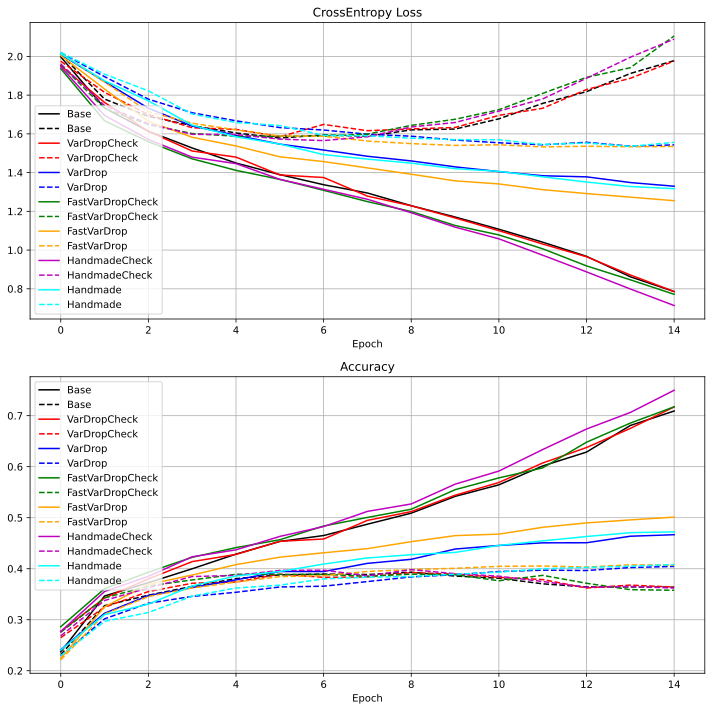

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x = np.arange(num_epochs)

axes[0].plot(x, [i.cpu() for i in metrics[0][0]], color=colors[0], label=titles[0])
axes[0].plot(x, [i.cpu() for i in metrics[0][2]], color=colors[0], label=titles[0], linestyle='--')

for color, metric, title in zip(colors[1:],metrics[1:],titles[1:]):
  axes[0].plot(x, [i.cpu() for i in metric[0]], color=color, label=title)
  axes[0].plot(x, [i.cpu() for i in metric[2]], color=color, label=title, linestyle='--')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')


axes[1].plot(x, metrics[0][1], color=colors[0], label=titles[0])
axes[1].plot(x, metrics[0][3], color=colors[0], label=titles[0], linestyle='--')

for color, metric, title in zip(colors[1:],metrics[1:],titles[1:]):
  axes[1].plot(x, metric[1], color=color, label=title)
  axes[1].plot(x, metric[3], color=color, label=title, linestyle='--')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:** можно заметить, что на трейне качество лучше без использования дропаута, однако на тесте качачество лучше с использованием дропаута, так как модели не переобучаются. Качество во всех трех моделях на тесте приблизительно одинаковое, поэтому если сравнивать модели, то лучше выбрать FastRNNLayer, так как по времени она самая быстрая.

## Бонус. Zoneout (2 балла)

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью p компонента скрытого состояния обновляется, а с вероятностью 1-p берется с предыдущего шага. 
В Виде формул (m^t_h - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

За основу возьмем RNNLayer.

In [ ]:
class Zoneout(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        h_0, c_0 = init_h0_c0(x.size()[1], self.hidden_size, x)
        # batch_size = amount of objects in batch
        # h_o.shape = (batch_size, hidden_size)
        # c_o.shape = (batch_size, hidden_size)

        # Gen masks for input and hidden state
        if self.dropout > 0:
          m_h, m_x = gen_dropout_mask(self.input_size,
                                      self.hidden_size,
                                      self.training, # self.training is from torch.nn.Module
                                      self.dropout,
                                      x)
          # m_h.shape = (hidden_size)
          # m_x.shape = (input_size)
        
        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        if self.dropout == 0:
          mask_x = x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = False
        elif self.dropout > 0:
          mask_x = x * m_x # mask_x.shape = (obj_len, batch_size, input_size)
          flag = True
        else:
          raise Exception("Dropout value should be >= 0")
        
        output = []
        h = h_0 # h.shape = (batch_size, hidden_size)
        c = c_0 # c.shape = (batch_size, hidden_size)
        for i in range(mask_x.size()[0]):
          h_t, c = self.rnn_cell(mask_x[i], (h, c))
          if flag:
            m_h, m_x = gen_dropout_mask(self.input_size,
                                      self.hidden_size,
                                      self.training, # self.training is from torch.nn.Module
                                      self.dropout,
                                      x)
            h = h_t*m_h + h*(1 - m_h)
          else:
            h = h_t
          output.append(h)
        output = torch.stack(output)
        return output, (h, c)

Очевидно, что случай dropout = 0 эквивалентен случаю использования RNNLayer без дропаута. Так что сразу протестирует реализацию с дропаутом.

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=Zoneout, dropout=0.25
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
start = time.time()
Zoneout_metrics = train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs)
Zoneout_DO_time = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.802/1.838. Accuracy (Train/Test): 0.328/0.312
Epoch: 2/15. Loss (Train/Test): 1.664/1.726. Accuracy (Train/Test): 0.359/0.344
Epoch: 3/15. Loss (Train/Test): 1.583/1.658. Accuracy (Train/Test): 0.381/0.359
Epoch: 4/15. Loss (Train/Test): 1.535/1.616. Accuracy (Train/Test): 0.403/0.372
Epoch: 5/15. Loss (Train/Test): 1.487/1.592. Accuracy (Train/Test): 0.414/0.384
Epoch: 6/15. Loss (Train/Test): 1.471/1.599. Accuracy (Train/Test): 0.421/0.387
Epoch: 7/15. Loss (Train/Test): 1.429/1.563. Accuracy (Train/Test): 0.430/0.393
Epoch: 8/15. Loss (Train/Test): 1.385/1.541. Accuracy (Train/Test): 0.448/0.403
Epoch: 9/15. Loss (Train/Test): 1.368/1.544. Accuracy (Train/Test): 0.456/0.402
Epoch: 10/15. Loss (Train/Test): 1.342/1.530. Accuracy (Train/Test): 0.465/0.407
Epoch: 11/15. Loss (Train/Test): 1.336/1.556. Accuracy (Train/Test): 0.464/0.404
Epoch: 12/15. Loss (Train/Test): 1.308/1.536. Accuracy (Train/Test): 0.476/0.411
Epoch: 13/15. Loss (Train/Test): 1.27

И качество и лосс схожи с предыдущими моделями при использовании дропаута. Переобучения нет.

In [ ]:
print('Время работы RNNLayer с дропаутом - ', RNNLayer_DO_time)
print('Время работы Zoneout с дропаутом - ', Zoneout_DO_time)

Время работы RNNLayer с дропаутом -  763.9747695922852
Время работы Zoneout с дропаутом -  1222.434707403183


Время работы по сравнению с RNNLayer увеличилось, и это ожидаемо, так как маска должна быть разная во все моменты времени.

# Часть 2. Language Modeling с помощью LSTM. (3 балла)

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации -- конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## Реализация модели и цикла обучения (1 балл)

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [20]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # Make embeddings for all tokens
        embeddings = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        rnn_output = self.rnn(embeddings)[0]
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        output = self.output(rnn_output)
        return output

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [ ]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [ ]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [22]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu(), batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu(), batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        loss = super().forward(packed_outputs, packed_tokens)
        return loss

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [23]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu(), batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu(), batch_first=False, enforce_sorted=False).data
        
        return torch.sum(torch.argmax(packed_outputs, dim=1) == packed_tokens)

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [42]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        # 2. Perform forward pass
        model.zero_grad()
        outputs = model(tokens, tokens_lens)
        # 3. Evaluate loss
        loss = loss_fn(outputs, tokens, tokens_lens+1)
        loss.backward()
        # 4. Make optimizer step
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            n = torch.sum(tokens_lens+1).item()
            # 2. Perform forward pass
            outputs = model(tokens, tokens_lens)
            # 3. Evaluate loss
            loss = loss_fn(outputs, tokens, tokens_lens+1)
            total_loss += loss.item() * n
            # 4. Evaluate accuracy
            accuracy = accuracy_fn(outputs, tokens, tokens_lens+1)
            total_accuracy += accuracy.item()
            
            total_tokens += n

    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [25]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# lm_vocab = torchtext.vocab.Vocab(counter, specials=specials, specials_first=True, max_size=30000)
lm_vocab = torchtext.vocab.vocab(counter, min_freq=9)

In [26]:
len(lm_vocab)

31145

In [27]:
lm_vocab.insert_token('<pad>', 0)
lm_vocab.insert_token('<unk>', 1)
lm_vocab.insert_token('<sos>', 2)
lm_vocab.insert_token('<eos>', 3)

In [28]:
lm_vocab.set_default_index(lm_vocab['<unk>'])

In [29]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [30]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=0, # здесь num_worker = 0 вместо 3
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=0, # здесь num_worker = 0 вместо 3
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце -- `<eos>` токен.

In [ ]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 4125,   488,  1500,  ...,  1190,  2845,   229],
         [ 9485,     1,   386,  ...,   700,   488,  6458],
         ...,
         [ 2160,   123,   391,  ..., 14357,    85,     1],
         [10226,   721,  3305,  ...,   693,  4601,  1077],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 20, 20,
         20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [43]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [44]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [45]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.525/7.650. Accuracy (Train/Test): 0.081/0.081
Epoch: 2/10. Loss (Train/Test): 7.302/7.505. Accuracy (Train/Test): 0.090/0.090
Epoch: 3/10. Loss (Train/Test): 7.069/7.376. Accuracy (Train/Test): 0.100/0.099
Epoch: 4/10. Loss (Train/Test): 6.854/7.295. Accuracy (Train/Test): 0.102/0.101
Epoch: 5/10. Loss (Train/Test): 6.650/7.248. Accuracy (Train/Test): 0.109/0.105
Epoch: 6/10. Loss (Train/Test): 6.496/7.260. Accuracy (Train/Test): 0.113/0.107
Epoch: 7/10. Loss (Train/Test): 6.305/7.254. Accuracy (Train/Test): 0.117/0.109
Epoch: 8/10. Loss (Train/Test): 6.157/7.266. Accuracy (Train/Test): 0.121/0.110
Epoch: 9/10. Loss (Train/Test): 6.005/7.296. Accuracy (Train/Test): 0.125/0.111
Epoch: 10/10. Loss (Train/Test): 5.858/7.316. Accuracy (Train/Test): 0.130/0.111


## Реализация декодера. (2 балла)

Теперь, реализуем последнюю деталь -- декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [ ]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = None
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        pass
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = None
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = None
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = None
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Evaluate embedding for next token
        # YOUR CODE HERE

        # Update hidden and cell states
        # YOUR CODE HERE

    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [ ]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.itos)[np.array(tokens)]
    print(' '.join(words))

<sos> first saw movie first time really disappointed really disappointed movie even one funniest films ever seen movie seen life <eos>
<sos> <unk> favorite movie ever seen movie really enjoyed first saw movie years ago thought would good movie <eos>
<sos> <unk> best movie ever seen movie ever made one thing bad acting bad acting bad effects bad bad script bad script bad acting
<sos> <unk> worst movie ever seen life life <unk> one best movies ever seen bad movies bad acting bad acting bad <eos>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [ ]:
# YOUR CODE HERE

**Ответ:**

## Бонус. Cущественное улучшение качества. (до 3 баллов)

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов
2. Dropout входов и выходов RNN
3. Регуляризация активаций (AR/TAR)
4. NT-ASGD
5. Tied веса эмбеддингов и софтмакса